# Class 13: Visualization 2 — Advanced Python

Goal of today's class:
1. Starting with a multilayer network visualization...
2. Add spatial elements and network links...
3. Try to reproduce fancy kepler.gl visualizaions!

__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_13/ folder.
________

In [1]:
import numpy as np
import itertools as it
import requests
from bs4 import BeautifulSoup

import networkx as nx
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib import rc

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

rc('axes', axisbelow=True, fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

________________
## Picking up where we left off...

A suggestion! (challenge)



![](images/keplergl.png)

How to visualize fancy 3D urban flow networks?

They really are just ("just") a combination of elements, which, when mastered, open the doors for all sorts of complicated, beautiful visualizations.

## Key features:
1. 3-dimensional plot
2. Dark background
3. Spatial data
4. Arching edges
5. Edge coloring by kernel density

## 3-D plot (multilayer network)

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [4]:
# let's start with the important stuff. pick your colors.
cols = ['steelblue', 'darksalmon', 'mediumseagreen']

np.random.seed(1)

# Imagine you have three node-aligned snapshots of a network
G1 = nx.karate_club_graph()
G2 = nx.karate_club_graph()
G3 = nx.karate_club_graph()

pos3 = nx.spring_layout(G1) # assuming common node location
graphs = [G1,G2, G3]

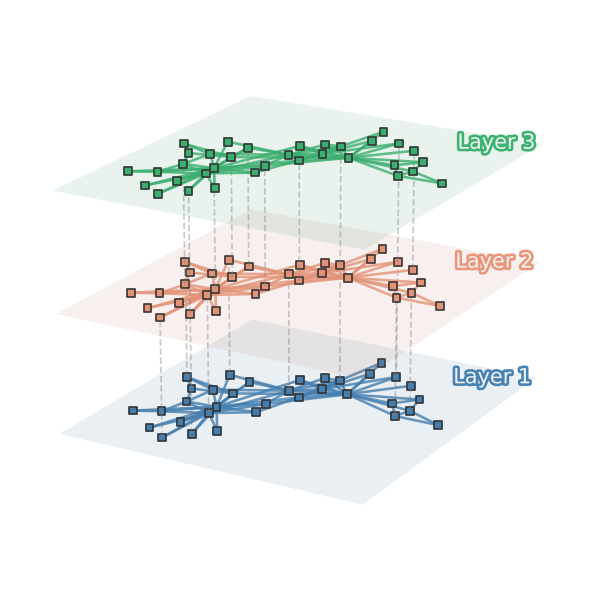

In [5]:
w = 9
h = 6

fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=125, subplot_kw={'projection':'3d'})

for gi, G in enumerate(graphs):
    # node positions
    xs = list(list(zip(*list(pos3.values())))[0])
    ys = list(list(zip(*list(pos3.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 

    # node colors
    cs = [cols[gi]]*len(xs)
    
    # if you want to have between-layer connections
    if gi > 0:
        thru_nodes = np.random.choice(list(G.nodes()),10,replace=False)
        lines3d_between = [(list(pos3[i])+[gi-1],list(pos3[i])+[gi]) for i in thru_nodes]
        between_lines = Line3DCollection(lines3d_between, zorder=gi, color='.5',
                                         alpha=0.4, linestyle='--', linewidth=1)
        ax.add_collection3d(between_lines)

    # add within-layer edges 
    lines3d = [(list(pos3[i])+[gi],list(pos3[j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=0.8)
    ax.add_collection3d(line_collection)
    
    # now add nodes
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2', marker='s', alpha=1, zorder=gi+1)
    
    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    layertext = ax.text(0.0, 1.15, gi*0.95+0.5, "Layer %i"%(gi+1),
                        color='.95', fontsize='large', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])

# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

# select viewing angle
angle = 30
height_angle = 20
ax.view_init(height_angle, angle)

# Optionally, adjust the 3D figure's aspect ratio or other properties for zoom
ax.set_box_aspect([4,4,3.25])  # Modify aspect ratio if necessary

ax.set_axis_off()

# plt.savefig('images/pngs/multilayer_network.png',dpi=425,bbox_inches='tight')
plt.show()

## Commuting data and spatial data

In [6]:
import pickle
with open('data/commuters.pickle', 'rb') as handle:
    commute_data = pickle.load(handle)

Now let's import a shapefile of the city of Boston.

In [7]:
import geopandas as gpd

In [8]:
boston_shp = gpd.read_file('data/2020_Census_Tracts_in_Boston/')

In [9]:
boston_shp.head()

,geoid20,countyfp20,namelsad20,statefp20,tractce20,intptlat20,name20,funcstat20,intptlon20,mtfcc20,aland20,awater20,objectid,geometry
0,25025140202,025,Census Tract,25,140202,+42.2495181,1402.02,S,-071.1175430,G5020,1538599,17120,1,"POLYGON ((757373.035 2913676.433, 757377.218 2..."
1,25025140300,025,Census Tract,25,140300,+42.2587734,1403,S,-071.1188131,G5020,1548879,38736,2,"POLYGON ((756308.459 2916770.814, 756446.058 2..."
2,25025140400,025,Census Tract,25,140400,+42.2692219,1404,S,-071.1118088,G5020,1874512,11680,3,"POLYGON ((757682.058 2924622.055, 757807.152 2..."
3,25025140106,025,Census Tract,25,140106,+42.2738738,1401.06,S,-071.1371416,G5020,278837,3116,4,"POLYGON ((753408.502 2925331.042, 753418.584 2..."
4,25025110201,025,Census Tract,25,110201,+42.2804960,1102.01,S,-071.1170508,G5020,348208,0,5,"POLYGON ((759003.960 2926858.165, 759043.378 2..."


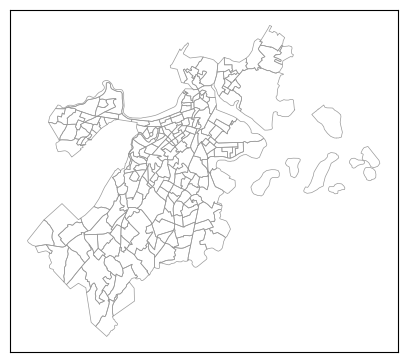

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)

boston_shp.plot(ax=ax,fc='none',ec='.6',lw=0.5)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_axis_off()


plt.show()

## Create the network for boston commutes

In [11]:
boston_tracts = boston_shp['geoid20'].values
boston_data = {i:j for i,j in commute_data.items() if i in boston_tracts}

In [12]:
G = nx.DiGraph()
for i in list(boston_data.keys()):
    present = boston_shp.loc[boston_shp['geoid20']==i].shape[0]
    if present != 0:
        
        # get the centroid for each census tract
        pos_i = [boston_shp.loc[boston_shp['geoid20']==i].geometry.centroid.x.values[0],
                 boston_shp.loc[boston_shp['geoid20']==i].geometry.centroid.y.values[0]]
        
        
        G.add_node(i, pos=pos_i, 
                      population=boston_data[i]['population'],
                      state=boston_data[i]['state'],
                      housing=boston_data[i]['housing'])
        edge_data = boston_data[i]['edge_data']
        for j in range(len(edge_data['edges'])):
            if edge_data['edges'][j] in boston_tracts:
                G.add_edge(i, edge_data['edges'][j],
                           weight=edge_data['weight'][j],
                           margin=edge_data['margin'][j])
    else:
        print(i)

pos = dict(nx.get_node_attributes(G,'pos'))
xs = list(list(zip(*list(pos.values())))[0])
ys = list(list(zip(*list(pos.values())))[1])

gp = nx.to_undirected(G)

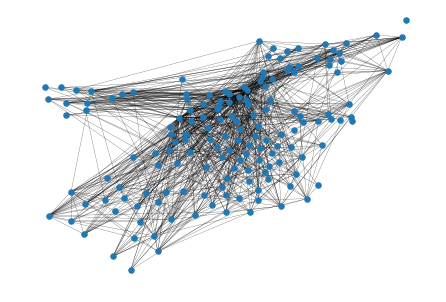

In [13]:
nx.draw(gp,pos=pos, width=0.2, node_size=30)

## Combine the two!

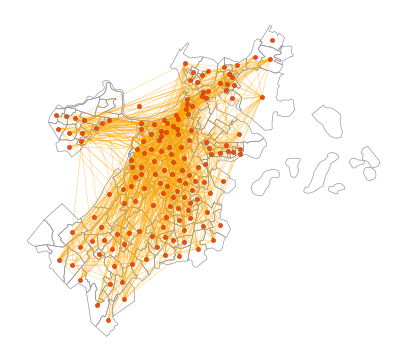

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)

boston_shp.plot(ax=ax,fc='none',ec='.6',lw=0.5)

nx.draw(gp, pos=pos, width=0.2, node_size=10, ax=ax, edge_color='orange',
        node_color='orangered', edgecolors='.2', linewidths=0.2)

ax.set_xticks([])
ax.set_yticks([])
# ax.set_axis_off()

plt.show()

In [15]:
from matplotlib.colors import LinearSegmentedColormap
from math import sqrt

# ---- inputs assumed available ----
# gp : (DiGraph or Graph) with edge attr 'weight'
# pos: dict {node: (x,y)}
# boston_shp: GeoDataFrame (for the basemap)

# --- helpers ---
def _weighted_degree(g):
    if isinstance(g, nx.DiGraph):
        return dict(g.in_degree(weight='weight'))  # you said "in-degree"
    return dict(g.degree(weight='weight'))

def _safe_minmax(x):
    mn, mx = float(np.min(x)), float(np.max(x))
    if mx - mn < 1e-12:
        mx = mn + 1e-12
    return mn, mx

In [16]:
# custom colormap: purple <- orange <- white  (white = most intense)
wop = LinearSegmentedColormap.from_list("wop", ["#6a00a8", "orange", "#ffffff"])

# ----- 1) node weights & coordinates -----
wd = _weighted_degree(gp)                        # weighted in-degree (or degree)
nodes = list(gp.nodes())
xy = np.array([pos[n] for n in nodes])          # N x 2
w = np.array([wd.get(n, 0.0) for n in nodes])   # sample weights

# ----- 2) KDE of node locations, weighted by weighted-degree -----
# Try SciPy KDE; fallback to simple Gaussian smoothing over nodes if SciPy absent.
try:
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(xy.T, weights=w, bw_method='scott')  # you can tweak bandwidth
    node_intensity = kde(xy.T)                              # intensity at node coords
except Exception:
    # lightweight fallback: RBF smoothing over nodes themselves
    # bandwidth = ~average nearest-neighbor distance
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=min(8, len(nodes))).fit(xy)
    dists, _ = nn.kneighbors(xy)
    bw = np.median(dists[:, 1]) if len(nodes) > 1 else 1.0
    # Gaussian kernel weights from all nodes (vectorized)
    # node_intensity[i] = Σ_j w_j * exp(-||xi - xj||^2 / (2*bw^2))
    diff2 = np.sum((xy[:, None, :] - xy[None, :, :])**2, axis=2)
    K = np.exp(-diff2 / (2 * bw**2))
    node_intensity = (K @ w) / (sqrt(2*np.pi) * bw)

# normalize to [0,1]
mn, mx = _safe_minmax(node_intensity)
node_norm = (node_intensity - mn) / (mx - mn + 1e-12)

# ----- 3) edge colors from endpoint intensities (and optional alpha from edge weight) -----
edges = list(gp.edges())
edge_endpoint_intensity = np.array([
    0.5 * (node_norm[nodes.index(u)] + node_norm[nodes.index(v)]) for u, v in edges
])

# edge alpha/width scaled by actual edge weight (log-scaled for dynamic range)
ew = np.array([gp[u][v].get('weight', 1.0) for u, v in edges], dtype=float)
ew_log = np.log1p(ew)
ew_mn, ew_mx = _safe_minmax(ew_log)
edge_alpha = 0.15 + 0.55 * ((ew_log - ew_mn) / (ew_mx - ew_mn + 1e-12))  # 0.15–0.70
edge_width = 0.2 + 1.3 * ((ew_log - ew_mn) / (ew_mx - ew_mn + 1e-12))    # 0.2–1.5

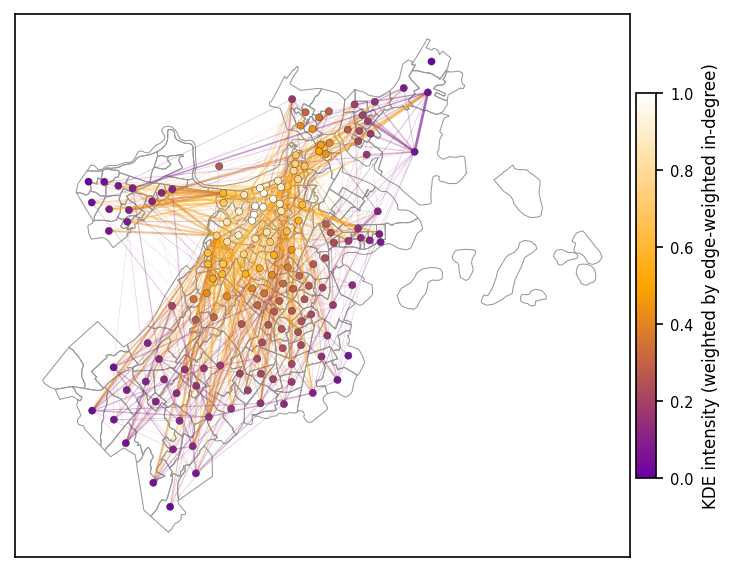

In [17]:
# ----- 4) plot -----
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
boston_shp.plot(ax=ax, fc='none', ec='.6', lw=0.5)

# draw edges with colormap by endpoint intensity
ecol = edge_endpoint_intensity
nx.draw_networkx_edges(
    gp, pos=pos, ax=ax,
    edge_color=ecol, edge_cmap=wop, edge_vmin=0.0, edge_vmax=1.0,
    alpha=None, width=edge_width
)

# we need to apply per-edge alpha manually (Matplotlib quirk)
# grab the last collection and set its alphas
edge_collection = ax.collections[-1]
edge_collection.set_alpha(None)  # enable per-segment alpha
edge_collection.set_array(ecol)  # keep colormap mapping
# per-segment alpha via segment-wise linewidths can't be set directly; instead:
try:
    # Matplotlib >= 3.8 exposes set_linestyle with alpha; otherwise skip
    alphas = edge_alpha
    # set individual alphas on segments:
    edge_collection.set_linestyle([(0, None)] * len(edges))  # noop to enable array props
    edge_collection.set_alpha(alphas)
except Exception:
    # if not supported, fall back to a single alpha based on median
    edge_collection.set_alpha(float(np.median(edge_alpha)))

# draw nodes colored by KDE intensity
ncol = node_norm
nx.draw_networkx_nodes(
    gp, pos=pos, ax=ax, node_size=12,
    node_color=ncol, cmap=wop, vmin=0.0, vmax=1.0,
    edgecolors='.2', linewidths=0.2
)

# clean up axes
ax.set_xticks([]); ax.set_yticks([])

# colorbar (node/edge share same [0,1] scale)
sm = plt.cm.ScalarMappable(cmap=wop)
sm.set_array([0,1])
cb = plt.colorbar(sm, ax=ax, fraction=0.030, pad=0.01)
cb.set_label('KDE intensity (weighted by edge-weighted in-degree)', fontsize=8)
cb.ax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()


## How to turn this into a 3d plot?

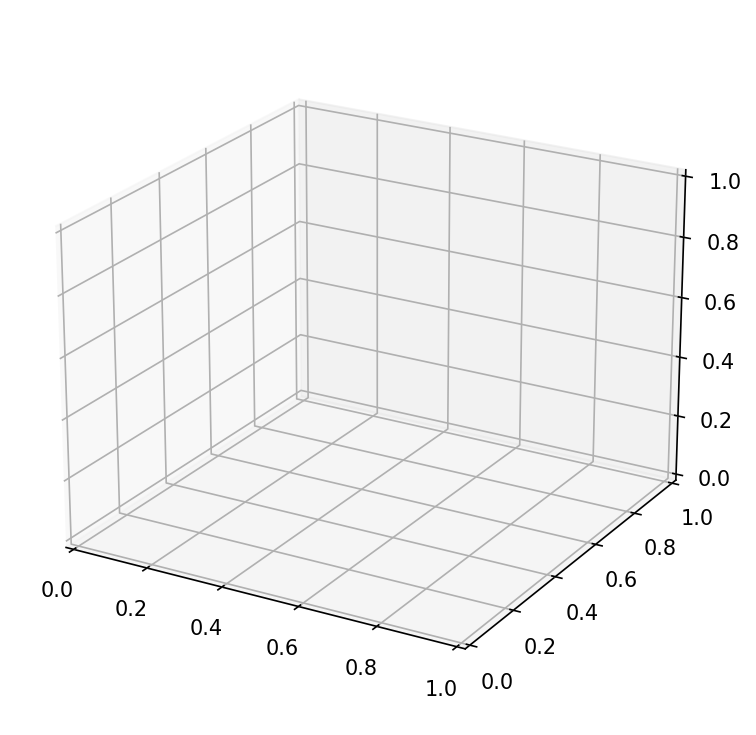

In [18]:
###################### PLOTTING ####################################

city_name = 'Boston'
layer_labels = ['Commute Data']

plot_edges=True

# Get bounds
xmin, ymin, xmax, ymax = boston_shp.total_bounds
xrange, yrange = xmax - xmin, ymax - ymin
ratio = yrange/xrange

# Plot setup
fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.add_subplot(111, projection='3d')


# # Set consistent view
# ax.set_xlim(xmin-xrange*0.025, xmax+xrange*0.025)
# ax.set_ylim(ymin-yrange*0.025, ymax+yrange*0.025)
# ax.set_zlim(-0.2, 0.2)
# ax.set_box_aspect([xrange * 1.0, yrange * 1.3, 1.0])  # scale Y to stretch vertically

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# Camera angle and appearance
ax.view_init(elev=22, azim=300)

plt.tight_layout()



plt.show()

## Next

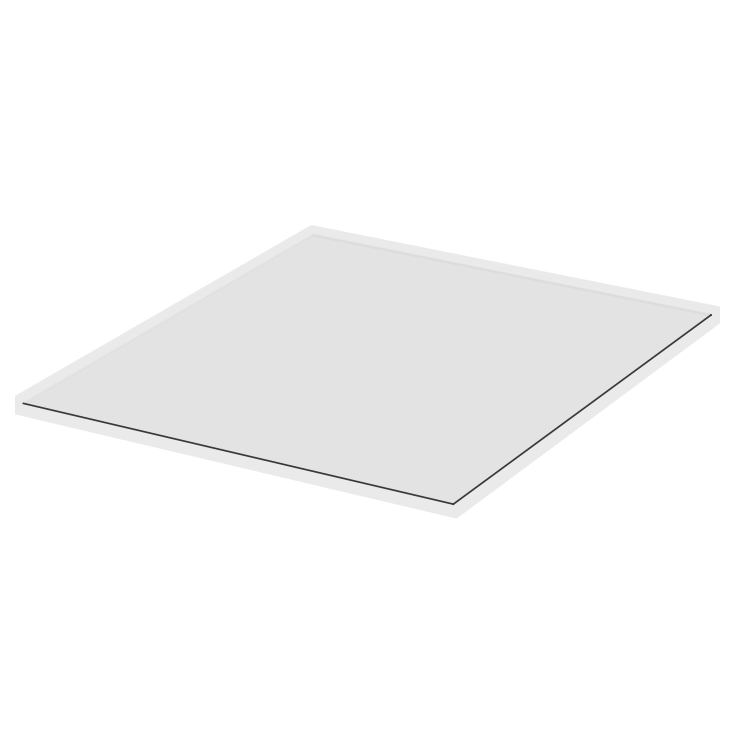

In [19]:
###################### PLOTTING ####################################

city_name = 'Boston'
layer_labels = ['Commute Data']

plot_edges=True

# Get bounds
xmin, ymin, xmax, ymax = boston_shp.total_bounds
xrange, yrange = xmax - xmin, ymax - ymin
ratio = yrange/xrange

# Plot setup
fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.add_subplot(111, projection='3d')





xx, yy = np.meshgrid([xmin-xrange*0.1*ratio, xmax+xrange*0.1*ratio],
                     [ymin-yrange*0.1, ymax+yrange*0.1])
zz_plane = np.full_like(xx, zz-0.01)
ax.plot_surface(xx, yy, zz_plane, color='.95', alpha=0.3)






# Set consistent view
ax.set_xlim(xmin-xrange*0.025, xmax+xrange*0.025)
ax.set_ylim(ymin-yrange*0.025, ymax+yrange*0.025)
ax.set_zlim(-0.2, 0.2)
ax.set_box_aspect([xrange * 1.0, yrange * 1.3, 1.0])  # scale Y to stretch vertically


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Camera angle and appearance
ax.view_init(elev=22, azim=300)

plt.tight_layout()



plt.show()

In [20]:
from shapely.geometry import Polygon, MultiPolygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

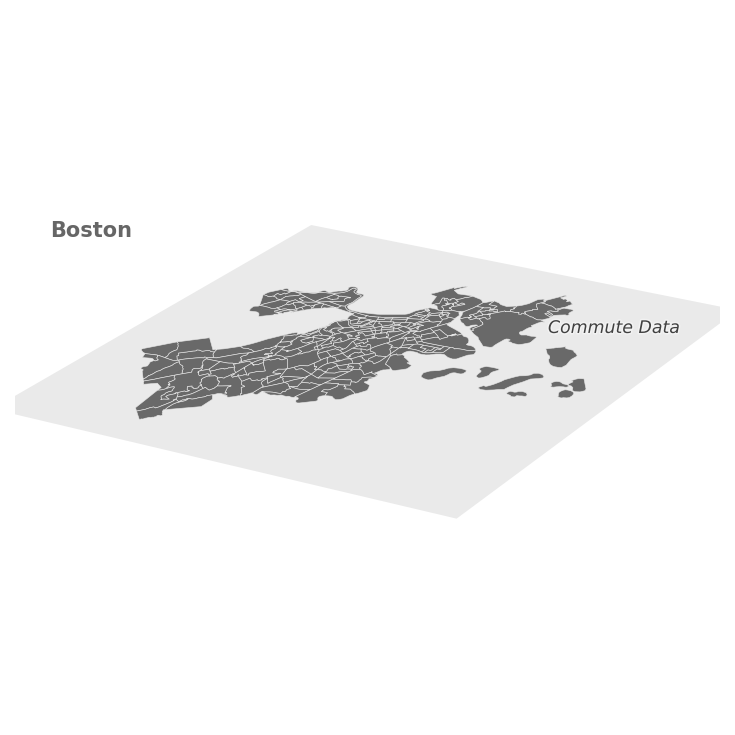

In [21]:
###################### PLOTTING ####################################

city_name = 'Boston'
layer_labels = ['Commute Data']

zz = 1

plot_edges=True

# Get bounds
xmin, ymin, xmax, ymax = boston_shp.total_bounds
xrange, yrange = xmax - xmin, ymax - ymin
ratio = yrange/xrange

crv_mean = 0.2

# Plot setup
fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.add_subplot(111, projection='3d')



# Set consistent view
ax.set_xlim(xmin-xrange*0.025, xmax+xrange*0.025)
ax.set_ylim(ymin-yrange*0.025, ymax+yrange*0.025)
ax.set_zlim(-0.2, 0.2)
ax.set_box_aspect([xrange*1.0, yrange*1.3, 1.0])  # scale Y to stretch vertically

####### DRAW THE BASE PLANE
xx, yy = np.meshgrid([xmin-xrange*0.1*ratio, xmax+xrange*0.1*ratio],
                     [ymin-yrange*0.1, ymax+yrange*0.1])
zz_plane = np.full_like(xx, zz-0.01)
ax.plot_surface(xx, yy, zz_plane, color='.95', alpha=0.3)


for geom in boston_shp.geometry:
    # Ensure iterable of polygons
    polys = [geom] if isinstance(geom, Polygon) else geom.geoms
    for poly in polys:
        exterior_coords = np.array(poly.exterior.coords)
        exterior_verts = [(x, y, zz) for x, y in exterior_coords]
        patch = Poly3DCollection([exterior_verts], alpha=0.9, linewidths=0.3)
        patch.set_facecolor('.2')

        patch.set_edgecolor('w')
        ax.add_collection3d(patch)




# add label
layertext = ax.text(xmax+xrange*0.02, ymax-yrange*0.05, zz, layer_labels[0], style='italic',
                    color='.25', fontsize='small', zorder=1e5, ha='right', va='center',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='.95'),
                                  path_effects.Normal()])





plt.title(city_name, y=0.75, fontsize='medium', x=0.05, ha='left', va='top',
          fontweight='bold', color='.4')

# Camera angle and appearance
ax.view_init(elev=22, azim=300)
ax.set_axis_off()
plt.tight_layout()



plt.show()

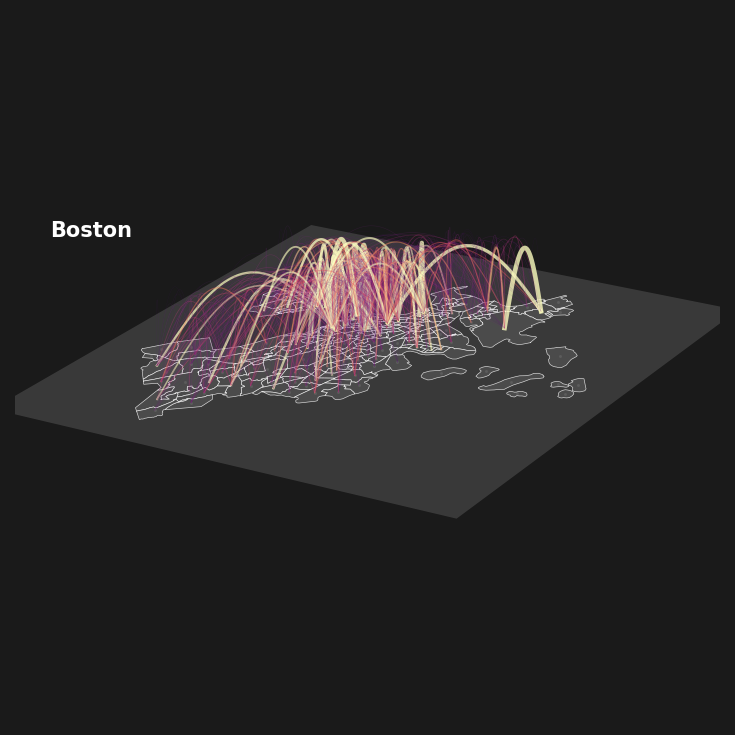

In [22]:
from matplotlib import colors

###################### PLOTTING ####################################

city_name = 'Boston'
layer_labels = ['Commute Data']

zz = 1

plot_edges=True

# Get bounds
xmin, ymin, xmax, ymax = boston_shp.total_bounds
xrange, yrange = xmax - xmin, ymax - ymin
ratio = yrange/xrange

crv_mean = 5000

# Plot setup

plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 5), dpi=150, facecolor='.1')
ax = fig.add_subplot(111, projection='3d', facecolor='.1')

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# fig = plt.figure(figsize=(10, 5), dpi=150)
# ax = fig.add_subplot(111, projection='3d')



####### DRAW THE BASE PLANE
xx, yy = np.meshgrid([xmin-xrange*0.1*ratio, xmax+xrange*0.1*ratio],
                     [ymin-yrange*0.1, ymax+yrange*0.1])
zz_plane = np.full_like(xx, zz-0.01)
ax.plot_surface(xx, yy, zz_plane, color='.95', alpha=0.2)

col = '.2'

layer_coords = {}
for ix,geom in enumerate(boston_shp.geometry):
    tract_i = boston_tracts[ix]
    layer_coords[tract_i] = [geom.centroid.x,geom.centroid.y,zz]
    # Ensure iterable of polygons
    polys = [geom] if isinstance(geom, Polygon) else geom.geoms
    for poly in polys:
        exterior_coords = np.array(poly.exterior.coords)
        exterior_verts = [(x, y, zz) for x, y in exterior_coords]
        patch = Poly3DCollection([exterior_verts], alpha=0.9, linewidths=0.3)
        patch.set_facecolor(col)

        patch.set_edgecolor('w')
        ax.add_collection3d(patch)

        ax.scatter(poly.centroid.x,
                   poly.centroid.y,
                   zz, color='.9', s=2, lw=0, 
                   zorder=1000000-1)
        



def plot_curved_line(x1, y1, z1, x2, y2, z2, ax, curvature=0.2,
                     zzz=100000000, ec=None, width=1, alpha=0.7):
    # Interpolate a curved line (e.g., arc) between (x1, y1, z1) and (x2, y2, z2)
    t = np.linspace(0, 1, 100)  # Parameter for interpolation
    x = (1 - t) * x1 + t * x2  # Linear interpolation of x
    y = (1 - t) * y1 + t * y2  # Linear interpolation of y
    z = (1 - t) * z1 + t * z2  # Linear interpolation of z (baseline)
    # Apply curvature in the z-direction
    z += curvature * np.sin(np.pi * t)  # Sinusoidal curve for an arch effect

    # Plot the curved line
    if ec==None:
        ec='.7'

    ax.plot(x, y, z, color=ec, lw=width/5, zorder=zzz, alpha=alpha)


xs = list(list(zip(*layer_coords))[0])
ys = list(list(zip(*layer_coords))[1])
zs = list(list(zip(*layer_coords))[2])

max_ew = max(list(nx.get_edge_attributes(G, 'weight').values()))

for edge in list(G.edges(data=True)):
    i, j = edge[:2]
    pos_i = layer_coords[i]
    pos_j = layer_coords[j]

    
    wid = 0.25 + np.array(edge[2]['weight'])/(max_ew/2)
    crv = np.random.normal(crv_mean, 0.04)

    norm = colors.Normalize(vmin=-0.1, vmax=1)
    ec = plt.cm.magma(norm(wid**2))

    plot_curved_line(pos_i[0], pos_i[1], pos_i[2],
                     pos_j[0], pos_j[1], pos_j[2], ax,
                     curvature=crv, ec=ec, width=(wid**2)*4,
                     alpha=0.8*min([np.array(edge[2]['weight'])/(max_ew/2), 1.0]))  # Adjust curvature as needed


plt.title(city_name, y=0.75, fontsize='medium', x=0.05, ha='left', va='top',
          fontweight='bold', color='w')


# Set consistent view
ax.set_xlim(xmin-xrange*0.025, xmax+xrange*0.025)
ax.set_ylim(ymin-yrange*0.025, ymax+yrange*0.025)
ax.set_zlim(-0.2, 0.2)
ax.set_box_aspect([xrange*1.0, yrange*1.3, 1.0])  # scale Y to stretch vertically


# Camera angle and appearance
ax.view_init(elev=22, azim=300)
ax.set_axis_off()
plt.tight_layout()


# plt.savefig("images/pngs/boston_commute_dark.png",
#             dpi=300, bbox_inches='tight', pad_inches=0, facecolor='black')
plt.show()

In [23]:
# --- curvature ~ f(distance) --------------------------------------
# precompute edge distances in XY
dists = []
for u, v in G.edges():
    pi = layer_coords[u]; pj = layer_coords[v]
    dists.append(np.hypot(pi[0] - pj[0], pi[1] - pj[1]))
dists = np.asarray(dists)
dmin, dmax = float(dists.min()), float(dists.max())



# set a curvature range relative to plot size (tweak these if you want more/less arch)
L = 0.5 * (xrange + yrange)          # characteristic XY scale
curv_min = 0.001 * L                 # arch for very short links
curv_max = 0.150 * L                 # arch for very long links
gamma = 0.95                         # <1 = sublinear, >1 = superlinear

def dist_to_curv(d):
    if dmax == dmin:
        return 0.5 * (curv_min + curv_max)
    x = (d - dmin) / (dmax - dmin)   # normalize to [0,1]
    x = np.clip(x, 0.0, 1.0) ** gamma
    return curv_min + x * (curv_max - curv_min)
# ------------------------------------------------------------------

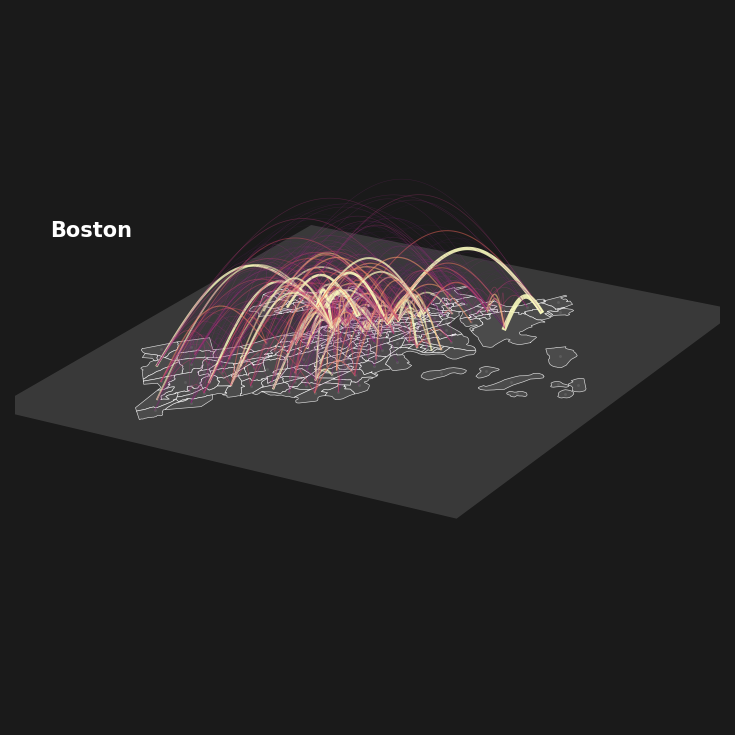

In [24]:
###################### PLOTTING ####################################

city_name = 'Boston'
layer_labels = ['Commute Data']

zz = 1

plot_edges=True

# Get bounds
xmin, ymin, xmax, ymax = boston_shp.total_bounds
xrange, yrange = xmax - xmin, ymax - ymin
ratio = yrange/xrange

crv_mean = 5000

# Plot setup

plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 5), dpi=150, facecolor='.1')
ax = fig.add_subplot(111, projection='3d', facecolor='.1')

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# fig = plt.figure(figsize=(10, 5), dpi=150)
# ax = fig.add_subplot(111, projection='3d')



####### DRAW THE BASE PLANE
xx, yy = np.meshgrid([xmin-xrange*0.1*ratio, xmax+xrange*0.1*ratio],
                     [ymin-yrange*0.1, ymax+yrange*0.1])
zz_plane = np.full_like(xx, zz-0.01)
ax.plot_surface(xx, yy, zz_plane, color='.95', alpha=0.2)

col = '.2'

layer_coords = {}
for ix,geom in enumerate(boston_shp.geometry):
    tract_i = boston_tracts[ix]
    layer_coords[tract_i] = [geom.centroid.x,geom.centroid.y,zz]
    # Ensure iterable of polygons
    polys = [geom] if isinstance(geom, Polygon) else geom.geoms
    for poly in polys:
        exterior_coords = np.array(poly.exterior.coords)
        exterior_verts = [(x, y, zz) for x, y in exterior_coords]
        patch = Poly3DCollection([exterior_verts], alpha=0.9, linewidths=0.3)
        patch.set_facecolor(col)

        patch.set_edgecolor('w')
        ax.add_collection3d(patch)

        ax.scatter(poly.centroid.x,
                   poly.centroid.y,
                   zz, color='.9', s=2, lw=0, 
                   zorder=1000000-1)
        



def plot_curved_line(x1, y1, z1, x2, y2, z2, ax, curvature=0.2,
                     zzz=100000000, ec=None, width=1, alpha=0.7):
    # Interpolate a curved line (e.g., arc) between (x1, y1, z1) and (x2, y2, z2)
    t = np.linspace(0, 1, 100)  # Parameter for interpolation
    x = (1 - t) * x1 + t * x2  # Linear interpolation of x
    y = (1 - t) * y1 + t * y2  # Linear interpolation of y
    z = (1 - t) * z1 + t * z2  # Linear interpolation of z (baseline)
    # Apply curvature in the z-direction
    z += curvature * np.sin(np.pi * t)  # Sinusoidal curve for an arch effect

    # Plot the curved line
    if ec==None:
        ec='.7'

    ax.plot(x, y, z, color=ec, lw=width/5, zorder=zzz, alpha=alpha)


xs = list(list(zip(*layer_coords))[0])
ys = list(list(zip(*layer_coords))[1])
zs = list(list(zip(*layer_coords))[2])

max_ew = max(list(nx.get_edge_attributes(G, 'weight').values()))

for edge in list(G.edges(data=True)):
    i, j = edge[:2]
    pos_i = layer_coords[i]
    pos_j = layer_coords[j]

    
    wid = 0.25 + np.array(edge[2]['weight'])/(max_ew/2)
#     crv = np.random.normal(crv_mean, 0.04)

    d = np.hypot(pos_i[0] - pos_j[0], pos_i[1] - pos_j[1])
    crv = dist_to_curv(d)

    norm = colors.Normalize(vmin=-0.2, vmax=1)
    ec = plt.cm.magma(norm(wid**2))

    plot_curved_line(pos_i[0], pos_i[1], pos_i[2],
                     pos_j[0], pos_j[1], pos_j[2], ax,
                     curvature=crv, ec=ec, width=(wid**2)*4,
                     alpha=0.9*min([np.array(edge[2]['weight'])/(max_ew/2), 1.0]))  # Adjust curvature as needed


plt.title(city_name, y=0.75, fontsize='medium', x=0.05, ha='left', va='top',
          fontweight='bold', color='w')


# Set consistent view
ax.set_xlim(xmin-xrange*0.025, xmax+xrange*0.025)
ax.set_ylim(ymin-yrange*0.025, ymax+yrange*0.025)
ax.set_zlim(-0.2, 0.2)
ax.set_box_aspect([xrange*1.0, yrange*1.3, 1.0])  # scale Y to stretch vertically


# Camera angle and appearance
ax.view_init(elev=22, azim=300)
ax.set_axis_off()
plt.tight_layout()


# plt.savefig("images/pngs/boston_commute_dark.png",
#             dpi=300, bbox_inches='tight', pad_inches=0, facecolor='black')
plt.show()

__________
## Next time...
Introduction to Machine Learning 1 — General `class_14_machine_learning1`
 
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. Github! Find papers with figures that you like and stalk the authors' github pages! I'll start with a few from my own github... https://github.com/jkbren/networks-and-dataviz?tab=readme-ov-file. But send over any that you like and we'll add them to the list!